In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import scipy.ndimage as spi
import os
import pandas as pd
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.visualization import SqrtStretch, imshow_norm, LogStretch, ZScaleInterval
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils import CircularAperture
from astropy.stats import sigma_clipped_stats
from photutils import DAOStarFinder
from astropy.nddata import Cutout2D
from skimage import restoration
import astropy as astro
from astropy.io import fits
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pylab as pylab
import astropy.units as u

plt.style.use("science")
params = {'legend.fontsize': 'x-large',
#           'figure.figsize': (10, 10),
         'axes.labelsize': 25,
         'axes.titlesize':25,
         'xtick.labelsize':25,
         'ytick.labelsize':25}
pylab.rcParams.update(params)

# from reproject import reproject_interp

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

np.set_printoptions(edgeitems=10)
np.core.arrayprint._line_width = 180
%matplotlib inline

In [7]:
datapath = os.getenv("project") + "/data/CosmicHorseshoe/hst_11602_02_wfc3_uvis_f814w_sci.fits"
data = fits.open(datapath)

In [179]:
data["SCI"].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 4291                                                  
NAXIS2  =                 4649                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
INHERIT =                    T / inherit the primary header                     
EXTNAME = 'SCI     '           / extension name                                 
EXTVER  =                    1 / extension version number                       
ROOTNAME= 'ib4802tkq                         ' / rootname of the observation set
EXPNAME = 'ib4802tkq                ' / exposure identifier                     
BUNIT   = 'ELECTRONS/S'     

In [9]:
data.info()

Filename: /home/alexandre/Desktop/Projects/data/CosmicHorseshoe/hst_11602_02_wfc3_uvis_f814w_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    1005   ()      
  1  SCI           1 ImageHDU        88   (4291, 4649)   float32   


In [22]:
exptime = data["PRIMARY"].header["EXPTIME"]
print(f"exposure time: {exptime} s")
image = data["SCI"].data * exptime # data is now a count
# weights = data["WHT"].data

exposure time: 5592.0 s


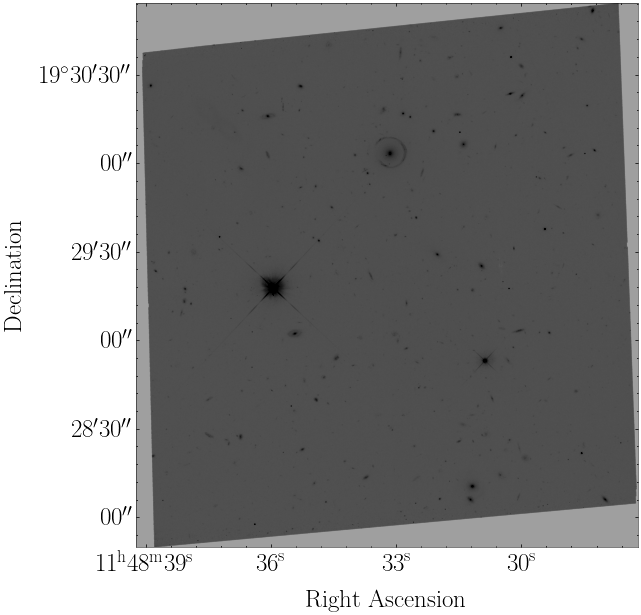

In [198]:
wcs = WCS(data["SCI"].header)
plt.figure(figsize=(10, 10))
plt.subplot(projection=wcs)
plt.imshow(image, cmap="gray_r", norm=ImageNormalize(stretch=LogStretch(), vmax=0.2))
# plt.colorbar()
ax = plt.gca()
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination');

# Find a patch of dark sky to estimate noise

In [85]:
# Right ascension	11h 48m 33.1s
# Declination	19° 30′ 03″
centroid = SkyCoord(177.13808, 19.50089, unit="deg")
centroid = centroid.to_pixel(wcs)
centroid # in pixel space

(array(2176.48364204), array(3361.47934944))

In [158]:
bkg_centroid = SkyCoord("11h48m30.1s", "+19.50089", unit=(u.hourangle, u.deg))
bkg_centroid = bkg_centroid.to_pixel(wcs)
x0, y0 = bkg_centroid
x1 = x0 - 150
x2 = x0 + 150
y1 = y0 - 150
y2 = y0 + 150
bkg_centroid # in pixel space

(array(3261.11020582), array(3361.52172117))

In [159]:
size = 300 * u.pixel
bkg_cutout = Cutout2D(image, bkg_centroid, size, wcs=wcs)
bkg_cutout_image = bkg_cutout.data
bkg_wcs_cutout = bkg_cutout.wcs
# cutout_image[cutout_image < 0] = 0

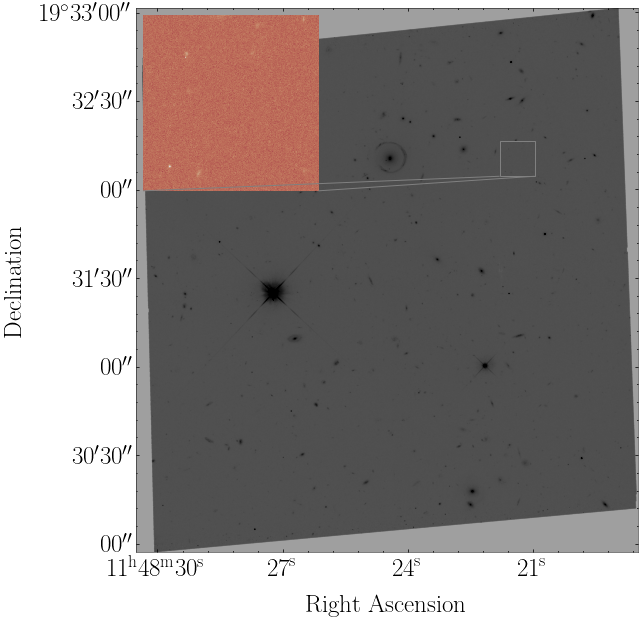

In [212]:
plt.figure(figsize=(10, 10))
plt.subplot(projection=bkg_wcs_cutout)
# plt.title("")
plt.imshow(image, cmap="gray_r", norm=ImageNormalize(stretch=LogStretch(), vmax=0.2))

ax = plt.gca()
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')
extent=[0, image.shape[1], 0, image.shape[0]]
axins = zoomed_inset_axes(ax, 5, loc=2) # zoom = 6
axins.imshow(image, interpolation="nearest", extent=extent, origin="lower", cmap="twilight", norm=ImageNormalize(stretch=LogStretch(), vmax=0.1))
axins.axis("off")
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
mark_inset(ax, axins, loc1=3, loc2=4, fc="none", ec="0.5");

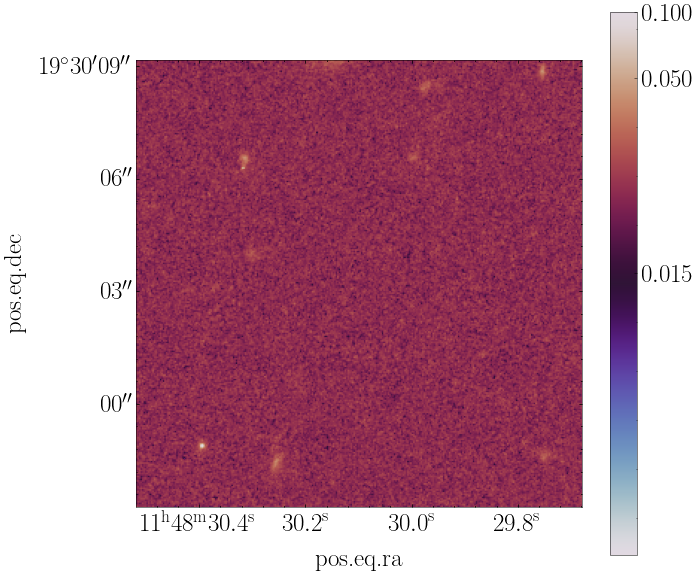

In [210]:
plt.figure(figsize=(10, 10))
plt.subplot(projection=bkg_wcs_cutout)
plt.imshow(bkg_cutout_image , cmap="twilight", norm=ImageNormalize(stretch=LogStretch()))
plt.colorbar(ticks=[0.015, 0.05, 0.1])

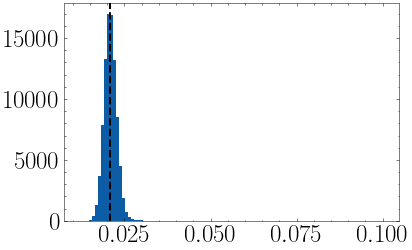

In [184]:
plt.hist(bkg_cutout_image.ravel(), bins=100);
plt.axvline(np.mean(bkg_cutout_image), ls="--", lw=2, color="k")

In [167]:
noise_sigma = np.mean(bkg_cutout_image)
noise_sigma

0.020883104

# Find a PSF candidate around the Horseshoe

In [218]:
size = 2000 * u.pixel
psf_cutout = Cutout2D(image, centroid, size, wcs=wcs)
psf_cutout_image = psf_cutout.data
psf_wcs_cutout = psf_cutout.wcs
# cutout_image[cutout_image < 0] = 0

In [270]:

mean, median, std = sigma_clipped_stats(psf_cutout_image,  sigma=100)
print(mean, median, std)
daofind = DAOStarFinder(fwhm=0.5, threshold=5.*std)
sources = daofind(psf_cutout_image)
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
object_positions = sources["xcentroid", "ycentroid"].to_pandas().to_numpy()
ox, oy = object_positions[:, 0], object_positions[:, 1]

sources[1:5]

0.021440174 0.021096928 0.0049661086


id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
2,1509.1050822430525,25.082308420727912,0.9999736848406714,0.33558365856931277,0.13918153419294096,25,0.0,0.10134488344192505,1.7084130888405995,-0.5814822251810885
3,1399.0782774476959,137.95238140619762,0.9999677372828879,-0.7568645762677927,-0.18000502423129627,25,0.0,0.8288426995277405,11.771597840003649,-2.6770885415602135
4,386.07871422731887,256.78638210793645,0.999967518632781,-0.23302171465754393,0.2422057303376355,25,0.0,0.5331858992576599,6.703702746564821,-2.065786871756647
5,588.1729750727186,262.81118298904255,0.9999715855642568,0.22357481850715655,-0.06162544833355851,25,0.0,0.1434701830148697,2.8883833060497826,-1.1516370656098047


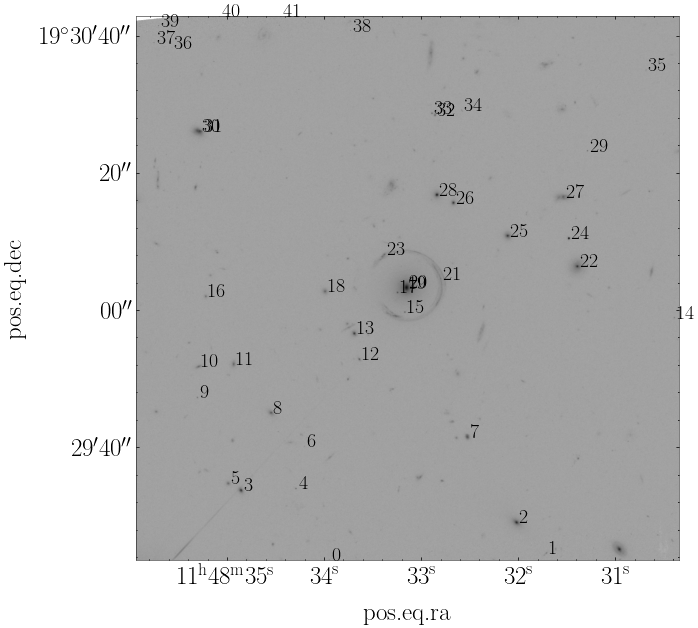

In [271]:
plt.figure(figsize=(10, 10))
plt.subplot(projection=psf_wcs_cutout)
# plt.title("")
plt.imshow(psf_cutout_image, cmap="gray_r", norm=ImageNormalize(stretch=LogStretch()))

ax = plt.gca()
for i in range(len(sources)):
    ax.annotate(f"{i}",  [ox[i]+10, oy[i]], color="k", fontsize=20)

# Make the Horshoe cutout

In [199]:
size = 500 * u.pixel
cutout = Cutout2D(image, centroid, size, wcs=wcs)
cutout_image = cutout.data
wcs_cutout = cutout.wcs
# cutout_image[cutout_image < 0] = 0

In [169]:
mean, median, std = sigma_clipped_stats(cutout_image,  sigma=10.0)
print(mean, median, std)
daofind = DAOStarFinder(fwhm=1.0, threshold=5.*std)
sources = daofind(cutout_image)
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
center = 4

object_positions = sources[[3, 2, 1, 0]]["xcentroid", "ycentroid"].to_pandas().to_numpy() # G, 01, 02, 03
ox, oy = object_positions[:, 0], object_positions[:, 1]

sources[0:4]

0.024070714 0.022630272 0.0058433535


id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
1,52.86148634653827,81.70865995345116,0.8876537459019392,-0.1296887393399925,0.16393433436830643,25,0.0,0.5127787590026855,7.0261064961194135,-2.116786820488326
2,238.17549724192844,160.79507789736462,0.891136920749638,0.07656551488330672,0.04798183545070001,25,0.0,0.15486864745616913,2.461188409627572,-0.9778621530395704
3,211.2964066004645,233.65599774234082,0.8996508149816796,-0.04316632463902323,0.06519870947954216,25,0.0,0.3188376724720001,5.559470671394593,-1.862583608705152
4,246.16924124682873,250.0775264941795,0.9001697330115813,0.09412892582670757,0.5402862291499666,25,0.0,0.925468385219574,2.8667610895166096,-1.1434787529208301


Text(0.5, 1.0, 'SDSS J114833.14+193003.2')

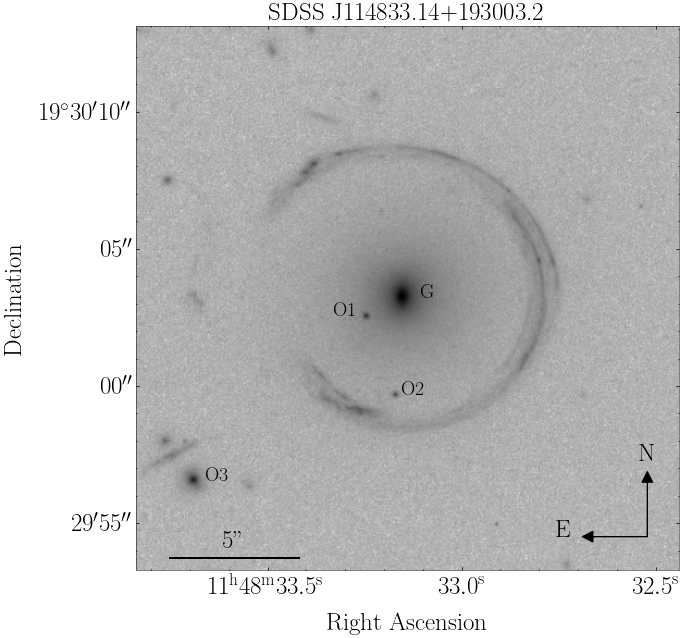

In [188]:
plt.figure(figsize=(10, 10))
plt.subplot(projection=wcs_cutout)
plt.imshow((cutout_image - noise_sigma), cmap="gray_r", norm=ImageNormalize(stretch=LogStretch()))
# plt.imshow(cutout_image > cutout_image.std())
ax = plt.gca()
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')
# plt.colorbar()

ax.annotate("G",  [ox[0]+15, oy[0]], color="k", fontsize=20)
ax.annotate("O1",  [ox[1]-30, oy[1]], color="k", fontsize=20)
ax.annotate("O2",  [ox[2]+5, oy[2]], color="k", fontsize=20)
ax.annotate("O3",  [ox[3]+10, oy[3]], color="k", fontsize=20)

N, M = cutout_image.shape
y = np.arange(N) #- N//2. + 0.5 * ((N + 1) % 2)
x = np.arange(M) #- M//2. + 0.5 * ((M + 1) % 2)
x, y = np.meshgrid(x, y)
lens_sky = wcs_cutout.pixel_to_world(x.ravel(), y.ravel())
x = lens_sky.ra.to(u.arcsec) -  lens_sky.ra.min()
y = lens_sky.dec.to(u.arcsec) - lens_sky.dec.min()
width = x.max().value
deltaPix = (x[1] - x[0]).value
x_center = (x[M//2]).to(u.arcsec).value
y_center = (y[M*N//2]).to(u.arcsec).value

#coordinate array
arrow_size = 0.02
color="k"
font_size = 25
width = 500
d0 = 30
p0 = 50
pt = 70

xx_, yy_ = (width - d0), d0
xx_ra, yy_ra = xx_ + p0, yy_
xx_dec, yy_dec = xx_, yy_ + p0
xx_ra_t, yy_ra_t = xx_ - 1.1*pt, yy_
xx_dec_t, yy_dec_t = xx_, yy_ + pt

ax.arrow(xx_ , yy_, -(xx_ra - xx_), -(yy_ra - yy_),
         head_width=arrow_size * width, head_length=arrow_size * width, fc=color, ec=color, linewidth=1)
ax.text(xx_ra_t, yy_ra_t, "E", color=color, fontsize=font_size, ha='center')
ax.arrow(xx_, yy_, (xx_dec - xx_), (yy_dec - yy_),
         head_width=arrow_size * width, head_length=arrow_size * width, fc=color, ec=color, linewidth=1)
ax.text(xx_dec_t, yy_dec_t, "N", color=color, fontsize=font_size, ha='center')

#scale bar
p0 = 150
dist = 5 / deltaPix
ax.plot([p0, p0 + dist], [10, 10], linewidth=2, color="k")
ax.text(p0 + dist / 2., 20, "5''", fontsize=font_size, color="k", ha='center')

ax.set_title("SDSS J114833.14+193003.2")